# Etap 3 - Trening modelu

Kolejny etap projektu skupia się na:

* Podzieleniu danych na zbiory testowe i treningowe.
* Treningu modelu.
* Serializacji wytrenowanego modelu.

## Spis treści
1. [Import bibliotek i inicjalizacja klienta Dask](#import-bibliotek-i-inicjalizacja-klienta-dask)
2. [Wczytanie danych](#wczytanie-danych)
3. [Podział danych](#podział-danych)
4. [Definicja modelu](#definicja-modelu)
5. [Trening modelu](#trening-modelu)
6. [Ewaluacja modelu](#ewaluacja-modelu)
7. [Serialiazacja modelu](#serializacja-modelu)

## Import bibliotek i inicjalizacja klienta Dask

In [28]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from dask_ml.metrics import mean_squared_error
from dask_ml.model_selection import GridSearchCV, train_test_split
from xgboost.dask import DaskXGBRegressor
import time

THIRD_POW_1024 = 1_073_741_824

In [2]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(
    processes=True,
    n_workers=2,
    threads_per_worker=4,
    memory_limit='12GB'
)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58922,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:58934,Total threads: 4
Dashboard: http://127.0.0.1:58936/status,Memory: 11.18 GiB
Nanny: tcp://127.0.0.1:58925,


## Wczytanie danych

In [3]:
def load_taxi_data(folder='processed_data', chunksize='128MB'):
    paths = []
    total_size = 0
    
    for i in range(1, 11):
        file_name = f'yellow_trip_data_processed_2024_{i:02d}'
        filepath = os.path.join(folder, file_name)
        
        if os.path.exists(filepath):
            paths.append(filepath)
            total_size += os.path.getsize(filepath)
            
        if not os.path.exists(filepath):
            print(f'Plik {file_name} nie istnieje.')
    
    if paths:
        total_size_gb = total_size / THIRD_POW_1024
        print(f'\nWczytywanie {len(paths)} plików...')
        print(f'Łączny rozmiar plików: {total_size_gb:.2f} GB przed dekompresją.\n\n')
        return dd.concat([dd.read_parquet(file, engine='pyarrow', chunksize=chunksize) for file in paths], ignore_index=True)
    if not paths:
        print('Nie znaleziono plików do wczytania')
        return None

In [4]:
ddf = load_taxi_data()
ddf.info()


Wczytywanie 10 plików...
Łączny rozmiar plików: 0.28 GB przed dekompresją.


<class 'dask_expr.DataFrame'>
Columns: 7 entries, trip_distance to trip_time_seconds
dtypes: float32(5), int16(1), int8(1)

## Podział danych
Z uwagi na zasoby sprzętowe, z danych zostanie wybrana ~~reprezentatywna (do pewnego stopnia)~~  próbka, na której zostanie zastosowana technika grid search.

Poniższy kod miał za zadanie podzielić dataset równomiernie ze względu na długość podróży, ale powoduje konflikt (?) z grid_search.

In [5]:
# bins = 10
# bin_edges = pd.cut(ddf['trip_distance'].compute(), bins=bins, retbins=True)[1]
# 
# ddf['distance_bins'] = ddf['trip_distance'].map_partitions(
#     lambda x: pd.cut(x, bins=bin_edges, labels=False),
#     meta=('distance_bins', 'int8')
# )
# 
# meta = {col: dtype for col, dtype in zip(ddf.columns, ddf.dtypes)}
# meta['distance_bins'] = 'int8'
# 
# ddf_sample = (
#     ddf.groupby('distance_bins', group_keys=False)
#        .apply(lambda x: x.sample(frac=0.1, random_state=42), meta=meta)
# )

In [6]:
ddf_sample = ddf.sample(frac=0.01, random_state=42)

### Weryfikacja próbki

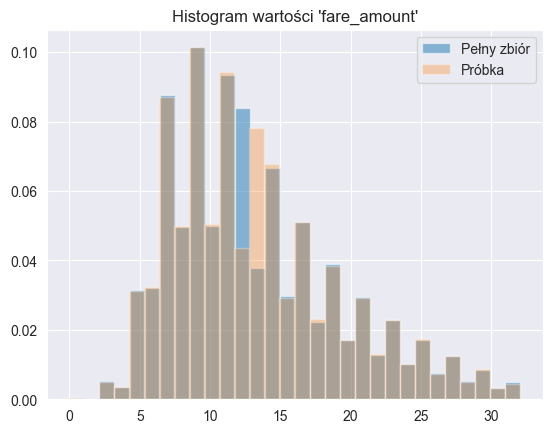

In [7]:
fare_amount_full = ddf['fare_amount'].compute()
fare_amount_sample = ddf_sample['fare_amount'].compute()

plt.hist(fare_amount_full, bins=30, density=True, alpha=0.5, label='Pełny zbiór')
plt.hist(fare_amount_sample, bins=30, density=True, alpha=0.3, label='Próbka')

plt.legend()
plt.title("Histogram wartości 'fare_amount'")
plt.show()

Próbka ma podobny rozkład co cały zbiór (względem kosztu przejazdu przed doliczeniem opłat).

In [8]:
# ddf = ddf.drop(['distance_bins'], axis=1)
# ddf_sample = ddf_sample.drop(['distance_bins'], axis=1)

target_column = 'tip_amount'
feature_cols = [col for col in ddf_sample.columns if col != target_column]

X = ddf_sample[feature_cols].to_dask_array(lengths=True)
y = ddf_sample[target_column].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Definicja modelu
Regresyjny model z biblioteki XGBoost (eXtreme Gradient Boosting) oparty na technice boostingu drzew decyzyjnych (boosting - metoda uczenia maszynowego, która iteracyjnie buduje modele, gdzie każdy kolejny model poprawia błędy poprzedniego).

In [9]:
xgb_reg = xgb.XGBRegressor(
    tree_method='hist'  # algorytm używany do budowy drzew - hist (histogram based) szybszy algorytm do dużych danych
)

Zakres parametrów do przeszukania.

In [10]:
param_grid = {
    'max_depth': [3, 5, 7],                     # max głębokość poj. drzewa decyzyjnego
    'eta': [0.01, 0.1, 0.3],                    # współczynnik uczenia
    'subsample': [0.7, 0.8, 0.9],               # procent próbek treningowych używanych do budowy każdego drzewa
    'min_child_weight': [1, 3, 5],              # minimalna suma wag próbek w liściu drzewa
    'colsample_bytree': [0.5, 0.7, 0.85, 1.0]   # procent cech wybranych losowo do budowy każdego drzewa (3 / 4 / 5 / 6)
}

### Grid search CV z użyciem Dask
Grid Search CV - metoda optymalizacji hiperparametrów w modelu. Polega na przeszukiwaniu wszystkich możliwych kombinacji wartości hiperparametrów zdefiniowanych w siatce (param_grid) w celu znalezienia zestawu parametrów, który daje najlepsze wyniki na danych walidacyjnych.

In [11]:
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # metryka oceny
    cv=3,                              # liczba foldów w walidacji krzyżowej
    n_jobs=-1                          # użycie wszystkich dostępnych workerów
)

## Trening modelu

In [12]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7, 0.85, 1.0],
                         'eta': [0.01, 0.1, 0.3], 'max_depth': [3, 5, 7],
                         'min_child_weight': [1, 3, 5],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error')

In [13]:
print(f'Najlepsze parametry: {grid_search.best_params_}')

Najlepsze parametry: {'colsample_bytree': 1.0, 'eta': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.9}


In [14]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importance_map = dict(zip(feature_cols, feature_importances))

sorted_features = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

print('Ważność cech (od najwyższej):')
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

Ważność cech (od najwyższej):
payment_type: 0.9002
fare_amount: 0.0885
tolls_amount: 0.0032
extra: 0.0031
trip_time_seconds: 0.0026
trip_distance: 0.0024


## Ewaluacja modelu

### Ocena modelu (wyuczonego na próbce)

In [15]:
y_pred = grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE na danych testowych: {rmse:.4f}")

RMSE na danych testowych: 1.1238


In [19]:
y_test_computed = y_test.compute()

stats = {
    'min': np.min(y_test_computed),
    'max': np.max(y_test_computed),
    'mean': np.mean(y_test_computed),
    'median': np.median(y_test_computed),
    'std_dev': np.std(y_test_computed),
    'q1': np.percentile(y_test_computed, 25),
    'q3': np.percentile(y_test_computed, 75)
}

print("Statystyki dla 'tip_amount' w y_test:")
for key, value in stats.items():
    print(f"{key.capitalize()}: {value:.4f}")

Statystyki dla 'tip_amount' w y_test:
Min: 0.0000
Max: 8.5000
Mean: 2.5853
Median: 2.6600
Std_dev: 1.8812
Q1: 1.0000
Q3: 3.8400


### Model uczony na całym datasecie (hiperparametry dobrane na podstawie powyższego modelu)

In [23]:
X = ddf_sample[feature_cols].to_dask_array(lengths=True)
y = ddf_sample[target_column].to_dask_array(lengths=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
xgb_dask_reg = DaskXGBRegressor(
    **grid_search.best_params_,
    tree_method='hist'
)

In [26]:
xgb_dask_reg.fit(X_train, y_train)

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.


DaskXGBRegressor(colsample_bytree=1.0, eta=0.1, max_depth=7, min_child_weight=5,
                 subsample=0.9, tree_method='hist')

### Porównanie modelu 'małego' i 'dużego'

In [27]:
y_pred_big = xgb_dask_reg.predict(X_test)
rmse_big = mean_squared_error(y_test, y_pred_big, squared=False)
print(f"RMSE na danych testowych (duży): {rmse_big:.4f} vs (mały) {rmse:.4f}")

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.


RMSE na danych testowych (duży): 1.1234 vs (mały) 1.1238


### Porównanie czasu inferencji

In [30]:
start = time.time()
y_pred_big = xgb_dask_reg.predict(X_test)
end = time.time()
print(f"Czas inferencji dla xgb_dask_reg: {end - start:.4f} s")

start = time.time()
y_pred_small = grid_search.best_estimator_.predict(X_test)
end = time.time()
print(f"Czas inferencji dla grid_search: {end - start:.4f} s")

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.


Czas inferencji dla xgb_dask_reg: 0.0733 s
Czas inferencji dla grid_search: 3.5246 s


Zatem zserializowany zostanie szybszy model o mniejszym RMSE.

## Serializacja modelu

In [31]:
xgb_dask_reg.save_model("xgb_dask_reg_model_tip_amount.json")